# Detector de estrellas candidatas a HVS
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies Catalog* (GCSCAT) integrado en Heasarc. 

### Requirements

In [104]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.project_vars import SELECTED_CLUSTERS, PATH
from hyper_velocity_stars_detection.etls.catalogs import CatalogsType
from hyper_velocity_stars_detection.astrobjects import AstroObjectProject
from hyper_velocity_stars_detection.jobs.cluster_selection_job import download_data
from hyper_velocity_stars_detection.tools.cluster_representations import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted, cmd_with_cluster, cluster_representation_with_hvs
from hyper_velocity_stars_detection.tools.cluster_detection import optimize_clustering, get_main_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
cluster = SELECTED_CLUSTERS[1]
project = download_data(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 5139 son:
Muestras seleccionadas del objeto astronómico ngc 5139 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 99125.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 21610.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 22572.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 23220.

Muestras seleccionadas del objeto astronómico ngc 5139 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 655.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 145.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 160.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 153.

Se han encontrado 6 fuentes de rayos X.



In [73]:
dfr1 = project.data_list[0].get_data("df_1_c2")
df_iso = load_isochrone_from_parsec("output258596335844.dat.txt")
distance_module, redding = get_best_isochrone_fitted(dfr1, df_iso)
distance_module, redding

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/hyper_velocity_stars_detection/tools/cluster_representations.py:62: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  


(np.float64(11.362885498500471), np.float64(0.014237175278627332))

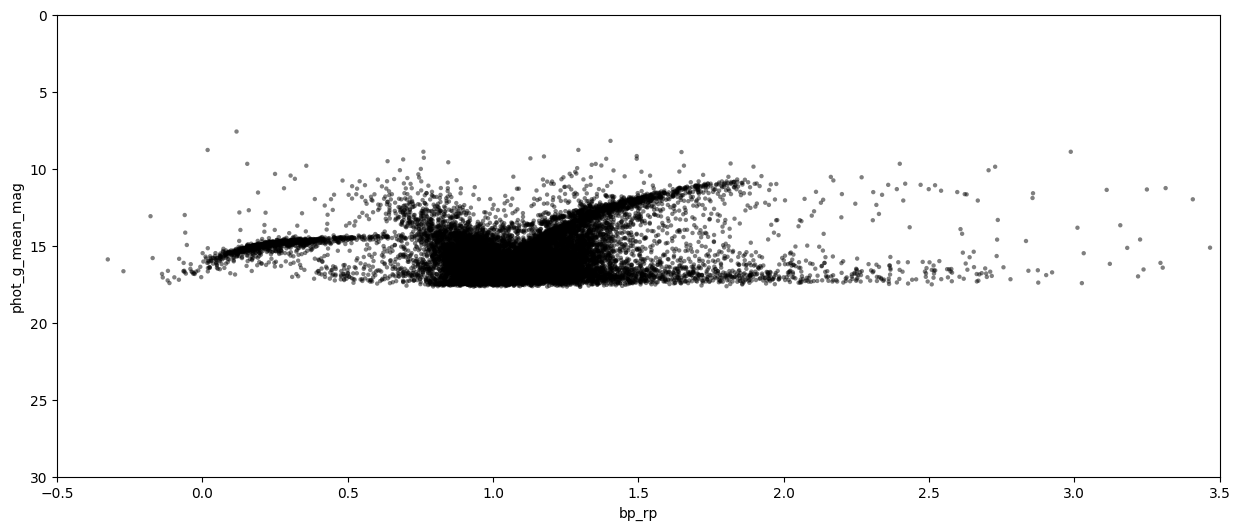

In [74]:
dfr1 = project.data_list[0].get_data("df_1_c1")

df_iso = None
ax, fig = cmd_plot(dfr1, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                  )
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

In [114]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 'phot_g_mean_mag'
                ]
clustering = optimize_clustering(
    df_stars=dfr1,
    columns=["pmra", "pmdec", "parallax"], 
    columns_to_clus=columns_to_clus,
    max_cluster=10,
    method="hdbscan",
    n_trials=30
)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

for label in np.unique(labels[labels >-1]):
    mask_i = labels == label
    print(f"Volumen total del cluster {label}: %d" % mask_i.sum())


[I 2025-02-27 01:08:41,495] A new study created in memory with name: no-name-c20aef1a-72dc-4ce3-96e2-77687ffbed4d
[I 2025-02-27 01:08:43,874] Trial 0 finished with value: 0.9502409352206909 and parameters: {'min_cluster_size': 31, 'min_samples': 9}. Best is trial 0 with value: 0.9502409352206909.
[I 2025-02-27 01:08:46,129] Trial 1 finished with value: 1.5207625562747633 and parameters: {'min_cluster_size': 86, 'min_samples': 4}. Best is trial 0 with value: 0.9502409352206909.
[I 2025-02-27 01:08:48,508] Trial 2 finished with value: 0.9545752880814062 and parameters: {'min_cluster_size': 31, 'min_samples': 10}. Best is trial 0 with value: 0.9502409352206909.
[I 2025-02-27 01:08:50,800] Trial 3 finished with value: 0.9533407434498807 and parameters: {'min_cluster_size': 65, 'min_samples': 5}. Best is trial 0 with value: 0.9502409352206909.
[I 2025-02-27 01:08:53,401] Trial 4 finished with value: 0.9523951847519427 and parameters: {'min_cluster_size': 38, 'min_samples': 4}. Best is trial

Estimated number of clusters: 6
Estimated number of noise points: 11693
Volumen total del cluster 0: 46
Volumen total del cluster 1: 25
Volumen total del cluster 2: 913
Volumen total del cluster 3: 6831
Volumen total del cluster 4: 1854
Volumen total del cluster 5: 167


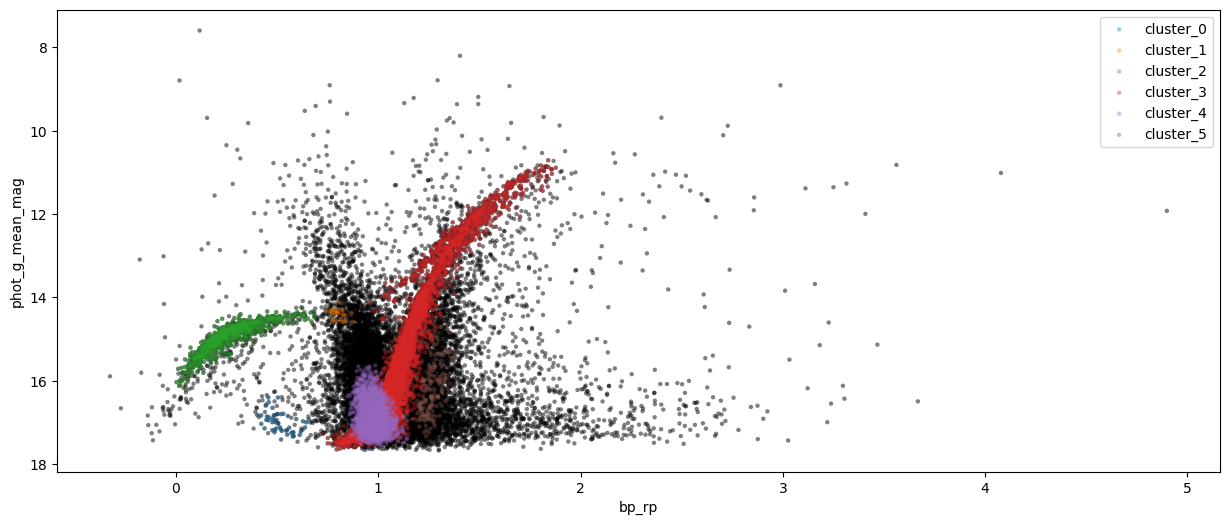

In [115]:
mask_nan = dfr1[columns_to_clus].isna().any(axis=1).values
data = dfr1[~mask_nan]

ax, fig = cmd_with_cluster(data, labels, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                          )
# ax.set_xlim(-0.5, 3.5)
# ax.set_ylim(30, 0)
plt.legend()
plt.show()

In [116]:
mask = labels == get_main_cluster(labels)
gc = data[mask]

print("Número de estrellas de CLuster seleccionado: %d" % gc.shape[0])
print("Número de HVS del CLuster seleccionado: %d" % gc[gc.pm_kms>200].shape[0])
display(gc[["pmra", "pmdec", "parallax"]].describe())

Número de estrellas de CLuster seleccionado: 6831
Número de HVS del CLuster seleccionado: 4247


,pmra,pmdec,parallax
count,6831.000000,6831.000000,6831.000000
mean,-3.251619,-6.748356,0.158931
std,0.433341,0.419971,0.079465
min,-4.924149,-8.436766,-0.210110
25%,-3.541259,-7.029724,0.116237
50%,-3.252373,-6.748003,0.158774
75%,-2.960267,-6.469578,0.199472
max,-1.520192,-5.150622,0.541611


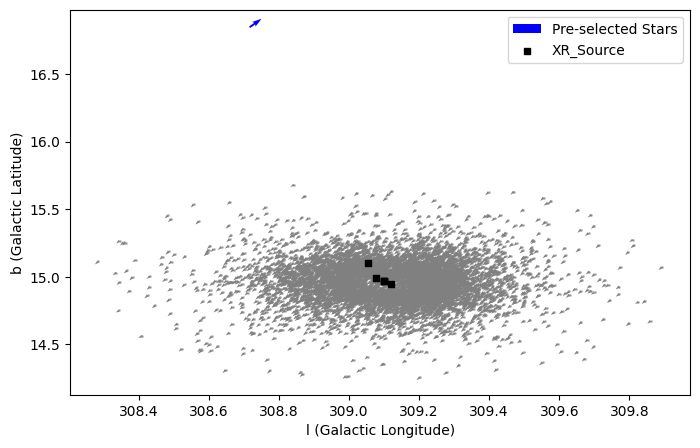

In [117]:
dfr6 = project.data_list[1].get_data("df_6_c2")

fig, ax = cluster_representation_with_hvs(gc, dfr6, hvs_pm=20, df_source_x=project.xsources)
plt.show()

## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.